In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import time
#starting time
st=time.time() 

#Data loading
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])

Traindata = datasets.MNIST('~/.pytorch/MNIST_data/',train=True,transform=transform,download=True)
Testdata = datasets.MNIST('~/.pytorch/MNIST_data/',train=False,transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(Traindata,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(Testdata,batch_size=128,shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!






/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


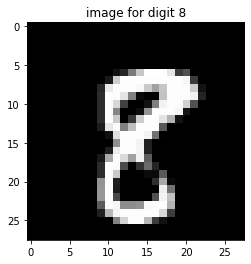

In [6]:
#data visualisation
import matplotlib.pyplot as plt
import torch.nn.functional as F
images,labels = next(iter(trainloader))
plt.imshow(images[0,0],cmap='gray')
plt.title('image for digit {}'.format(labels[0].numpy()))
plt.show()

In [69]:
#Network architecture
class cnn(nn.Module):
  def __init__(self):
    super(cnn,self).__init__()
    self.C1=nn.Conv2d(1,32,3)
    self.pool=nn.MaxPool2d(2,2)
    self.C2=nn.Conv2d(32,64,3)
    self.fc1=nn.Linear(9216,128)
    self.fc2=nn.Linear(128,10)
    self.dropout2=nn.Dropout(0.25)
    self.dropout1=nn.Dropout(0.5)
    self.softmax=nn.Softmax(dim=1)
  def forward(self,x):
    x=F.relu(self.C1(x))
    x=F.relu(self.C2(x))
    x=self.pool(x)
    x=x.view(x.shape[0],-1)
    x=self.dropout2(x)
    x=F.relu(self.fc1(x))
    x=self.dropout1(x)
    x=self.fc2(x)
    return x

model=cnn()
#running on gpu or not
train_on_gpu= torch.cuda.is_available()
if train_on_gpu:
  model.cuda()


In [70]:
#optimizer and loss method selection
from torch import optim
optimizer=optim.RMSprop(model.parameters(),lr=0.0001,momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [71]:
#Training the model
epochs=5
model.train()
for e in range(epochs):
  running_loss=0
  for images,labels in trainloader:
    optimizer.zero_grad()
    if train_on_gpu:
      images,labels=images.cuda(),labels.cuda() 
    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  print('epoch:{}  loss:{:.5f}'.format(e+1,running_loss/len(trainloader)))  

epoch:1  loss:0.20219
epoch:2  loss:0.07855
epoch:3  loss:0.05936
epoch:4  loss:0.04932
epoch:5  loss:0.04297


In [72]:
#Testing the model
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for images,labels in testloader:
  if train_on_gpu:
    images,labels=images.cuda(),labels.cuda()
  output=model(images)
  loss=criterion(output,labels)
  test_loss+=loss.item()
  _,predict=torch.max(output,dim=1)
  correct=predict.eq(labels.data.view_as(predict)) 
  correct = np.squeeze(correct.numpy()) if not train_on_gpu else np.squeeze(correct.cpu().numpy()) 
  for i in range(labels.shape[0]):
    label=labels.data[i]
    class_correct[label]+=correct[i]
    class_total[label]+=1

#printing accuracy for each digit and for whole network
for i in range(10):
  print('Accuracy for digit {} is {:.2f}%'.format(i,100*class_correct[i]/class_total[i]))
print('Net Accuracy is ',100*(np.sum(class_correct)/np.sum(class_total)),'%')
print('Net time taken:{:.2f}s'.format(time.time()-st))  

Accuracy for digit 0 is 99.59%
Accuracy for digit 1 is 99.56%
Accuracy for digit 2 is 99.52%
Accuracy for digit 3 is 99.60%
Accuracy for digit 4 is 99.69%
Accuracy for digit 5 is 98.77%
Accuracy for digit 6 is 98.96%
Accuracy for digit 7 is 98.93%
Accuracy for digit 8 is 98.56%
Accuracy for digit 9 is 98.51%
Net Accuracy is  99.18 %
Net time taken:59.82s
